# Grover's Algorithm

### Details @ https://en.wikipedia.org/wiki/Grover%27s_algorithm

# Imports

In [9]:
import qckt
from qckt.backend import *
import numpy as np
import random as rnd

# Qubits assignment for the algorithm

In [10]:
ufinpsz = 4
inpreg = [i for i in reversed(range(ufinpsz))]
outreg = [ufinpsz]
nqbits = ufinpsz + 1

# The 'needle' in the haytack to be searched = marker

In [11]:
marker = int(rnd.random() * (2**(nqbits-1)-1))
print(("Marker to search = {0:0"+str(nqbits-1)+"b}, ({0:d})").format(marker))

Marker to search = 1000, (8)


# The oracle circuit

In [12]:
uf_ckt = qckt.QCkt(nqbits,name="Uf")
uf_ckt.Border()
x_list = []
for i in range(len(inpreg)):
	if (marker & (0b1<<i)) == 0:
		x_list.append(inpreg[-i-1]) # index i backwards from the end of inpreg
if len(x_list) > 0:
	uf_ckt.X(x_list)
uf_ckt.CX(*(inpreg+outreg)) # target of the CX operation is outreg qubit
if len(x_list) > 0:
	uf_ckt.X(x_list)
uf_ckt.Border()
uf_ckt.draw()

Uf
q000 --#-[X]-[.]-[X]--#-
       #      |       # 
q001 --#-[X]-[.]-[X]--#-
       #      |       # 
q002 --#-[X]-[.]-[X]--#-
       #      |       # 
q003 --#-----[.]------#-
       #      |       # 
q004 --#-----[X]------#-
       #              # 
creg ==#==============#=
       #              # 


# The diffuser circuit

In [13]:
amp_ckt = qckt.QCkt(nqbits,name="Diffuser")
amp_ckt.H(inpreg)
amp_ckt.X(inpreg)
amp_ckt.CX(*(inpreg+outreg))   ## This is how Umesh Vazirni explains it
# amp_ckt.CZ(*inpreg) ## Gives identical results ... since still invertig phase of the inputs register.
amp_ckt.X(inpreg)
amp_ckt.H(inpreg)
amp_ckt.draw()

Diffuser
q000 -[H]-[X]-[.]-[X]-[H]-
               |          
q001 -[H]-[X]-[.]-[X]-[H]-
               |          
q002 -[H]-[X]-[.]-[X]-[H]-
               |          
q003 -[H]-[X]-[.]-[X]-[H]-
               |          
q004 ---------[X]---------
                          
creg =====================
                          


# The initializer circuit

In [14]:
init_ckt = qckt.QCkt(nqbits,name="Initialize")
init_ckt.H(inpreg)
# setup the result qubit in |-> state for phase kickback
init_ckt.X(outreg)
init_ckt.H(outreg)
init_ckt.draw()

Initialize
q000 -[H]---------
                  
q001 -[H]---------
                  
q002 -[H]---------
                  
q003 -[H]---------
                  
q004 -----[X]-[H]-
                  
creg =============
                  


# Assemble the full Grover's algorithm circuit

In [15]:
fullckt = qckt.QCkt(nqubits=nqbits,nclbits=nqbits,name="Full Grover's Circuit")
fullckt = fullckt.append(init_ckt)

fullckt.Probe("after initialization", probestates=[marker])
numitrs = int((np.pi/4.0) * (2.0**((nqbits-1.0)/2.0))) # optimal # iter, less or more dont work
print("Number of Invert-Diffuser iterations = ",numitrs)

for itr in range(numitrs):
	fullckt = fullckt.append(uf_ckt)
	fullckt = fullckt.append(amp_ckt)
	fullckt.Probe("after iteration "+str(itr+1), probestates=[marker])
fullckt.M(inpreg)
fullckt.draw()

Number of Invert-Diffuser iterations =  3
Full Grover's Circuit
q000 -[H]----------v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v-[M]-
                   v  #      |       #          |           v  #      |       #          |           v  #      |       #          |           v  |  
q001 -[H]----------v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v-[M]-
                   v  #      |       #          |           v  #      |       #          |           v  #      |       #          |           v  |  
q002 -[H]----------v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--v-[M]-
                   v  #      |       #          |           v  #      |       #          |           v  #      |       #          |           v  |  
q003 -[H]----------v--#-----[.]------#-[H]

# Run the circuit multiple times, display the stats of readouts

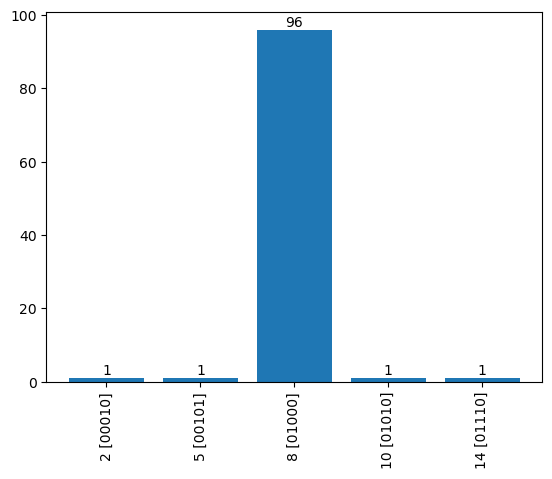

In [16]:
job = qckt.Job(fullckt, shots=100)
bk = Qeng()  # to run multiple shots, and see stats of readouts
# bk = Qdeb()  # to see Probe on state of interest
bk.runjob(job)
_ = job.plot_counts()